In [1]:
!pip install qiskit -q

In [3]:
!pip install qiskit[machine-learning] -q

Package                      Version
---------------------------- ------------
absl-py                      2.0.0
anyio                        4.0.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.4.0
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.1.0
Babel                        2.12.1
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       6.0.0
cachetools                   5.3.2
certifi                      2023.7.22
cffi                         1.16.0
charset-normalizer           3.2.0
colorama                     0.4.6
comm                         0.1.4
contourpy                    1.1.1
cycler                       0.12.0
debugpy                      1.8.0
decorator                    5.1.1
defusedxml                   0.7.1
dill                         0.3.9
executing                    1.2.0


In [3]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

from qiskit import BasicAer
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data

seed = 12345
algorithm_globals.random_seed = seed

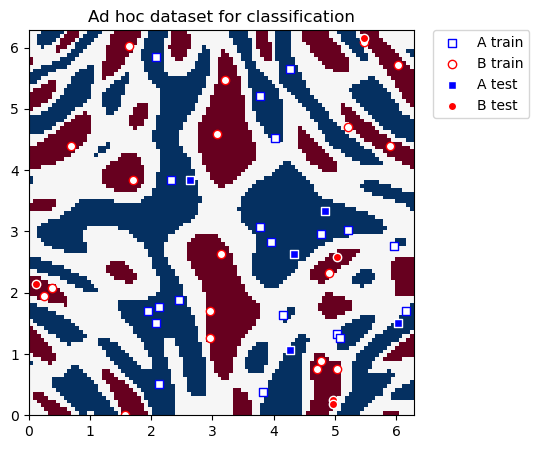

In [4]:
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

plt.scatter(
    train_features[np.where(train_labels[:] == 0), 0],
    train_features[np.where(train_labels[:] == 0), 1],
    marker="s",
    facecolors="w",
    edgecolors="b",
    label="A train",
)
plt.scatter(
    train_features[np.where(train_labels[:] == 1), 0],
    train_features[np.where(train_labels[:] == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="B train",
)
plt.scatter(
    test_features[np.where(test_labels[:] == 0), 0],
    test_features[np.where(test_labels[:] == 0), 1],
    marker="s",
    facecolors="b",
    edgecolors="w",
    label="A test",
)
plt.scatter(
    test_features[np.where(test_labels[:] == 1), 0],
    test_features[np.where(test_labels[:] == 1), 1],
    marker="o",
    facecolors="r",
    edgecolors="w",
    label="B test",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset for classification")

plt.show()

In [5]:
adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

In [6]:
adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)
adhoc_svc.fit(train_features, train_labels)
adhoc_score = adhoc_svc.score(test_features, test_labels)

print(f"Callable kernel classification test score: {adhoc_score}")

Callable kernel classification test score: 1.0


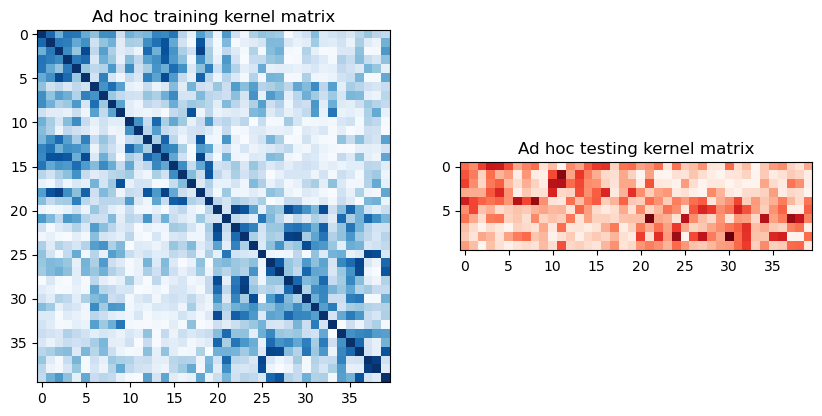

Precomputed kernel classification test score: 1.0


In [7]:
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(
    np.asmatrix(adhoc_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")
axs[1].imshow(np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")
plt.show()

adhoc_svc = SVC(kernel="precomputed")
adhoc_svc.fit(adhoc_matrix_train, train_labels)
adhoc_score = adhoc_svc.score(adhoc_matrix_test, test_labels)

print(f"Precomputed kernel classification test score: {adhoc_score}")

In [8]:
qsvc = QSVC(quantum_kernel=adhoc_kernel)
qsvc.fit(train_features, train_labels)
qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 1.0
